# Benchmarking Seq2Seq on Chaotic Oscillators

Seq2Seq models have been shown to be effective in modeling chaotic systems. This benchmark contains code to train and evaluate Seq2Seq models on the following chaotic systems :
  - [Lorenz](###Lorenz)
  - [Fibonacci](###Fibonacci)
  - [Van Der Pol](###Van-Der-Pol)

## Setup

In [1]:
import os
import sys
import torch

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from src.utils.seed_utils import set_global_seeds
except ImportError:
    raise ImportError("Cannot import module. Make sure that the project is on the path")

SEED = 42
set_global_seeds(seed=SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Preprocessing


In [2]:
BATCH_SIZE = 64

### Lorenz


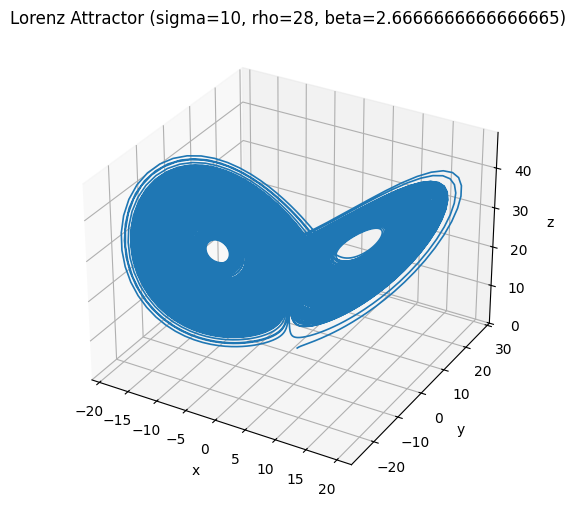

Train size: 39954, Test size: 9989, Batch size: 64


In [ ]:
from src.data_sources.lorenz import LorenzOscillator
from src.utils.dataset_utils import DatasetUtils

# For model feed
LORENZ_INPUT_LAYERS = 3
LORENZ_OUTPUT_LAYERS = 3

initial_state = [1.0, 1.0, 1.0]
t_span = (0, 500)
max_step = 1e-2

lorenz = LorenzOscillator(sigma=10, rho=28, beta=8.0 / 3.0)

dataset = lorenz.preprocess_and_create_dataset(
    initial_state=initial_state,
    t_span=t_span,
    max_step=max_step,
    input_length=50,
    target_length=10,
)

lorenz.plot_trajectory(initial_state=initial_state, t_span=t_span, max_step=max_step)

lorenz_train_dataset, lorenz_test_dataset = DatasetUtils().train_test_split(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    train_ratio=0.8,
    shuffle_train=True,
    shuffle_test=False,
)

## Seq2Seq

### Training

In [4]:
import torch
from torch.utils.tensorboard import SummaryWriter
from src.schemas.paths_schema import PathsSchema
from tqdm import tqdm
from src.models import seq2seq
from src.utils.torch_utils import criterion_choice
from src.utils.tensorboard_utils import launch_tensorboard

# Hyperparameters
hidden_size = 128
num_layers = 3
dropout = 0.2
teacher_forcing_ratio = 0.5
loss_function = "mse"
learning_rate = 1e-6
num_epochs = 1000

# Model setup
encoder = seq2seq.Encoder(LORENZ_INPUT_LAYERS, hidden_size, num_layers, dropout).to(
    device
)
decoder = seq2seq.Decoder(LORENZ_OUTPUT_LAYERS, hidden_size, num_layers, dropout).to(
    device
)
model = seq2seq.Seq2Seq(encoder, decoder).to(device)

criterion = criterion_choice(loss_function)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For tensorboard logs
paths = PathsSchema(
    model_name=os.path.join(
        "lorenz",
        "seq2seq",
        f"seed_{SEED}_batch_size_{BATCH_SIZE}_input_{LORENZ_INPUT_LAYERS}"
        f"_hidden_{hidden_size}_layers_{num_layers}_dropout_{dropout}_loss_{loss_function}"
        f"_lr_{learning_rate}_num_epochs_{num_epochs}",
    )
)
writer = SummaryWriter(log_dir=paths.tensorboard_log_model)

# Display model graph in tensorboard
# dummy_input = torch.randn(1, 10, input_size).to(device)
# writer.add_graph(lstm, dummy_input)

launch_tensorboard(paths.tensorboard_log_model)

best_train_loss = 0
best_test_loss = 0

for epoch in tqdm(range(num_epochs)):
    # Training
    model.train()
    train_loss = 0

    for x, y in lorenz_train_dataset:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x, y, teacher_forcing_ratio=teacher_forcing_ratio)
        # out (batch_size, y_seq_len, output_size)
        # y (batch_size, y_seq_len, output_size)
        loss = criterion(outputs, y)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(lorenz_train_dataset)

    # Evaluation
    model.eval()
    test_loss = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for x, y in lorenz_test_dataset:
            x, y = x.to(device), y.to(device)

            outputs = model(x, y, teacher_forcing_ratio=0)
            loss = criterion(outputs, y.squeeze(dim=1))

            test_loss += loss.item()

    avg_test_loss = test_loss / len(lorenz_test_dataset)

    writer.add_scalars("Loss", {"train": avg_train_loss, "test": avg_test_loss}, epoch)

    if (epoch + 1) % (num_epochs // 10) == 0:
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}"
        )

writer.close()

torch.save(
    model.state_dict(),
    paths.model_path
    + f"epoch_{epoch}_train_loss_{avg_train_loss:.4f}_test_loss_{avg_test_loss:.4f}.pt",
)


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784



TensorBoard started at http://localhost:6007/


  0%|          | 0/1000 [00:00<?, ?it/s]

Opening in existing browser session.


 10%|█         | 100/1000 [12:53<1:55:32,  7.70s/it]

Epoch 100/1000, Train Loss: 0.0269, Test Loss: 0.0265


 20%|██        | 200/1000 [25:44<1:43:03,  7.73s/it]

Epoch 200/1000, Train Loss: 0.0266, Test Loss: 0.0264


 30%|███       | 300/1000 [38:37<1:29:59,  7.71s/it]

Epoch 300/1000, Train Loss: 0.0266, Test Loss: 0.0264


 40%|████      | 400/1000 [51:28<1:17:09,  7.72s/it]

Epoch 400/1000, Train Loss: 0.0266, Test Loss: 0.0264


 50%|█████     | 500/1000 [1:04:18<1:04:03,  7.69s/it]

Epoch 500/1000, Train Loss: 0.0265, Test Loss: 0.0264


 60%|██████    | 600/1000 [1:17:11<51:31,  7.73s/it]  

Epoch 600/1000, Train Loss: 0.0265, Test Loss: 0.0264


 70%|███████   | 700/1000 [1:30:03<38:33,  7.71s/it]

Epoch 700/1000, Train Loss: 0.0265, Test Loss: 0.0264


 80%|████████  | 800/1000 [1:40:39<20:06,  6.03s/it]

Epoch 800/1000, Train Loss: 0.0265, Test Loss: 0.0264


 90%|█████████ | 900/1000 [1:50:46<10:07,  6.08s/it]

Epoch 900/1000, Train Loss: 0.0265, Test Loss: 0.0264


100%|██████████| 1000/1000 [2:00:54<00:00,  7.25s/it]

Epoch 1000/1000, Train Loss: 0.0265, Test Loss: 0.0264


### Evaluation

#### Multi-Step Evaluation

Sample #1:
  True:
 [[0.36484003 0.38293317 0.43944368]
 [0.36328927 0.37804163 0.4325285 ]
 [0.3612251  0.37283096 0.42613623]
 [0.358654   0.36729273 0.42030182]
 [0.35558087 0.36141872 0.4150638 ]] ...
  Pred:
 [[0.         0.         0.        ]
 [0.3647878  0.3806725  0.43260977]
 [0.36274493 0.37567002 0.4257972 ]
 [0.3600207  0.3694237  0.4203071 ]
 [0.3562274  0.3628434  0.41492978]] ...


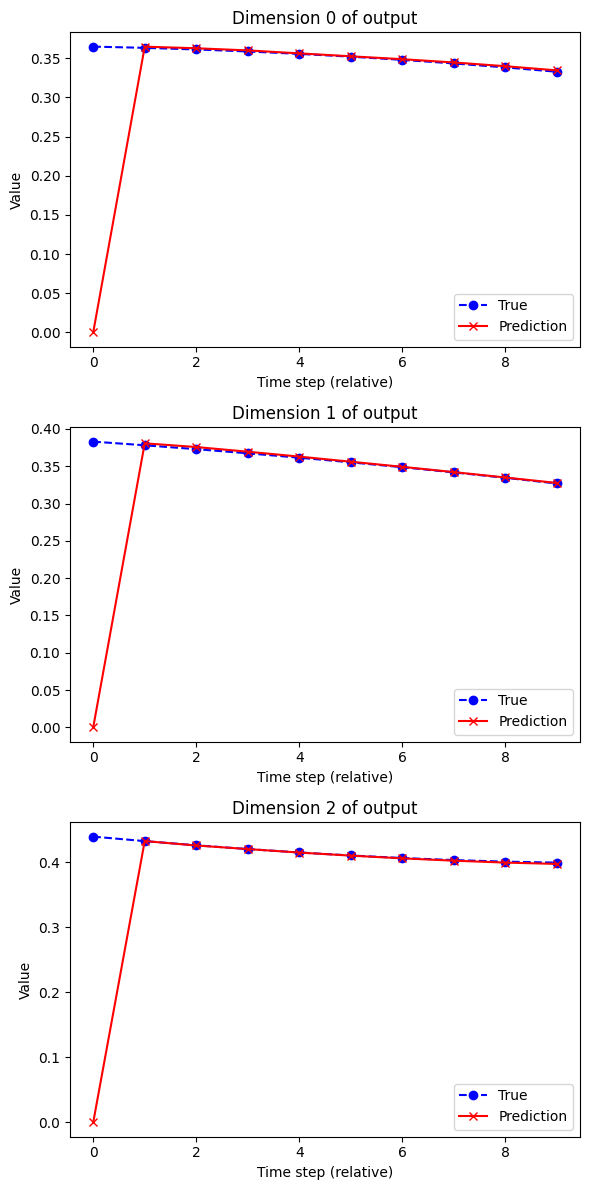

Sample #2:
  True:
 [[0.17314202 0.15064804 0.49981728]
 [0.15950868 0.14724883 0.53091663]
 [0.14694688 0.14720732 0.5632745 ]
 [0.13581875 0.15087919 0.5961854 ]
 [0.12649019 0.15848844 0.62881845]] ...
  Pred:
 [[0.         0.         0.        ]
 [0.161226   0.14706312 0.5273624 ]
 [0.14804322 0.14689177 0.56066716]
 [0.13697043 0.14999025 0.5935315 ]
 [0.12683691 0.15806586 0.6259155 ]] ...


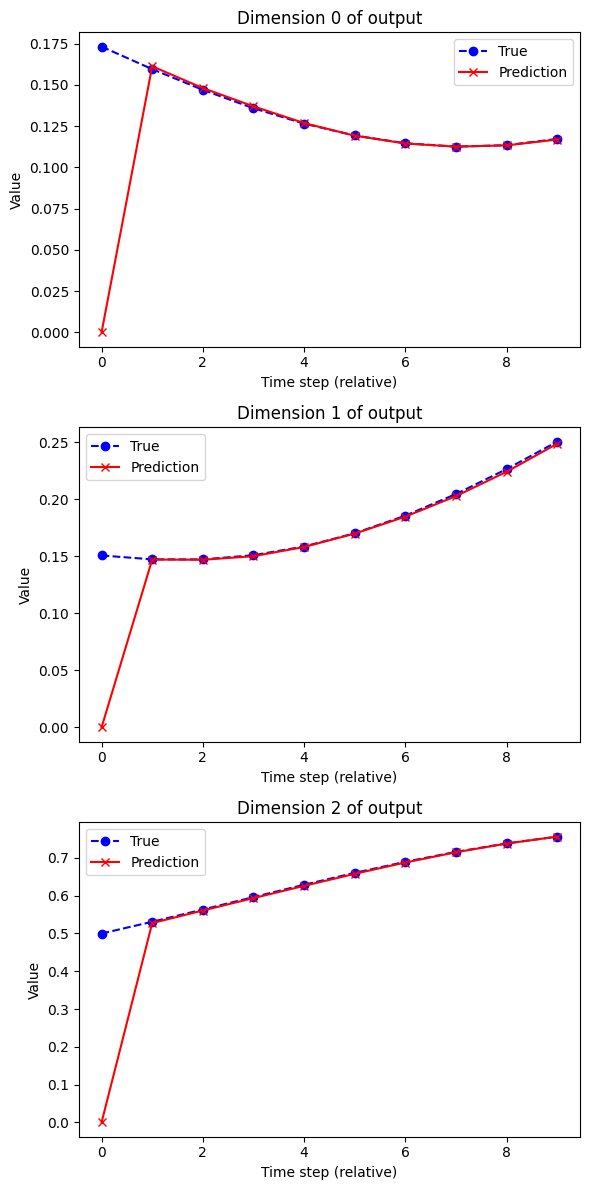

Sample #3:
  True:
 [[0.44670397 0.5541198  0.5794117 ]
 [0.46002793 0.5533323  0.56260693]
 [0.47197387 0.5524619  0.54663706]
 [0.48267084 0.55163527 0.5314322 ]
 [0.4922502  0.5509499  0.5169292 ]] ...
  Pred:
 [[0.         0.         0.        ]
 [0.4597038  0.5546935  0.5631608 ]
 [0.47224182 0.55210704 0.5485883 ]
 [0.48288074 0.55298626 0.531841  ]
 [0.49251556 0.55182666 0.515867  ]] ...


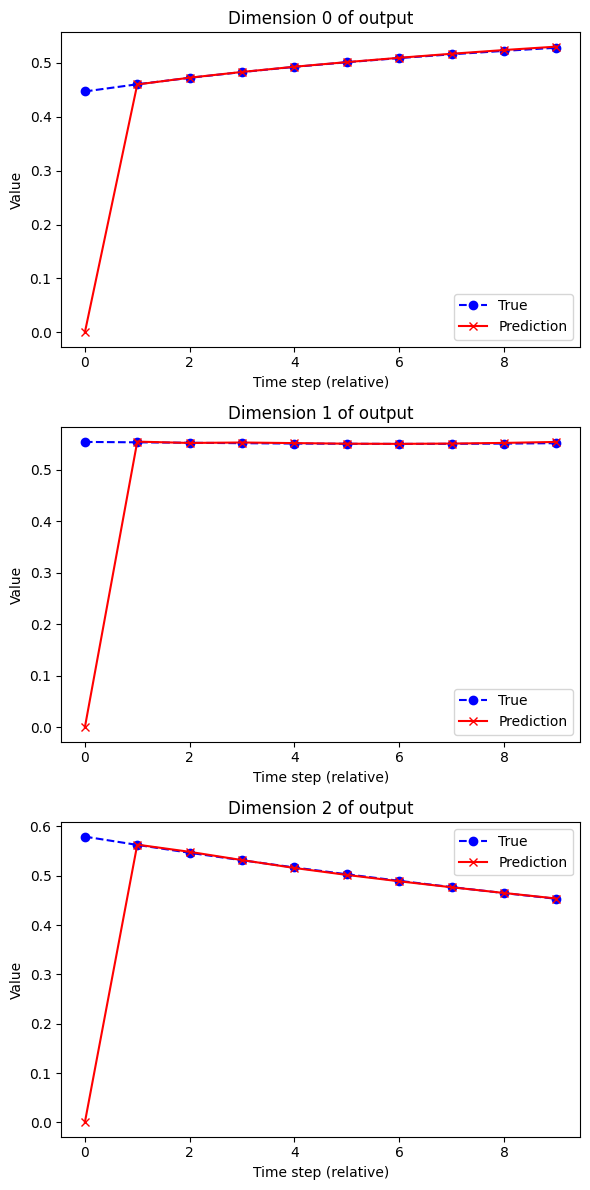

In [ ]:
import matplotlib.pyplot as plt

num_plots = 3

model.eval()

# We'll store predictions for the first `num_plots` we encounter
samples_plotted = 0

for x_batch, y_batch in lorenz_test_dataset:
    # Move to GPU if needed
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    # Inference
    with torch.no_grad():
        # outputs shape: (batch_size, y_seq_len, output_dim)
        outputs = model(
            x_batch, y_batch, teacher_forcing_ratio=0.0
        )

    # Convert to CPU numpy for plotting
    outputs_np = outputs.detach().cpu().numpy()  # shape (B, y_seq_len, out_dim)
    y_true_np = y_batch.detach().cpu().numpy()  # shape (B, y_seq_len, out_dim)

    batch_size = outputs_np.shape[0]

    # Plot up to batch_size or until we've hit num_plots
    for b in range(batch_size):
        if samples_plotted >= num_plots:
            break  # done plotting

        # For each sample in the batch
        pred_seq = outputs_np[b]  # shape (y_seq_len, out_dim)
        true_seq = y_true_np[b]  # shape (y_seq_len, out_dim)

        # Quick numeric comparison (print the first few points)
        print(f"Sample #{samples_plotted+1}:")
        print("  True:\n", true_seq[:5], "...")
        print("  Pred:\n", pred_seq[:5], "...")

        # Now let's plot each dimension over the time steps
        seq_len = pred_seq.shape[0]
        time_axis = range(seq_len)  # 0..(seq_len-1)

        fig, axes = plt.subplots(
            nrows=pred_seq.shape[1], ncols=1, figsize=(6, 4 * pred_seq.shape[1])
        )
        if pred_seq.shape[1] == 1:
            # If we only have 1 dimension to predict, 'axes' won't be a list
            axes = [axes]

        for dim_i in range(pred_seq.shape[1]):
            axes[dim_i].plot(
                time_axis,
                true_seq[:, dim_i],
                label="True",
                color="blue",
                marker="o",
                linestyle="--",
            )
            axes[dim_i].plot(
                time_axis,
                pred_seq[:, dim_i],
                label="Prediction",
                color="red",
                marker="x",
            )
            axes[dim_i].set_title(f"Dimension {dim_i} of output")
            axes[dim_i].set_xlabel("Time step (relative)")
            axes[dim_i].set_ylabel("Value")
            axes[dim_i].legend()

        plt.tight_layout()
        plt.show()

        samples_plotted += 1